In [37]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from xgboost import XGBClassifier, plot_importance
from scipy.stats import circmean, circstd, vonmises
warnings.filterwarnings('ignore')
start_time = time.time()

In [38]:
data_train = pd.read_csv('fraudTrain.csv')

Training set for Credit Card Transactions

index - Unique Identifier for each row

trans_date_trans_time - Transaction DateTime

cc_num - Credit Card Number of Customer

merchant - Merchant Name

category - Category of Merchant

amt - Amount of Transaction

first - First Name of Credit Card Holder

last - Last Name of Credit Card Holder

gender - Gender of Credit Card Holder

street - Street Address of Credit Card Holder

city - City of Credit Card Holder

state - State of Credit Card Holder

zip - Zip of Credit Card Holder

lat - Latitude Location of Credit Card Holder

long - Longitude Location of Credit Card Holder

city_pop - Credit Card Holder's City Population

job - Job of Credit Card Holder

dob - Date of Birth of Credit Card Holder

trans_num - Transaction Number

unix_time - UNIX Time of transaction

merch_lat - Latitude Location of Merchant

merch_long - Longitude Location of Merchant

is_fraud - Fraud Flag <--- Target Class

# Preprocessing

## Handling Nulls and Duplicates

In [39]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [40]:
data_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [41]:
data_train.tail()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0
1296674,1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,...,45.8433,-113.8748,218,"Therapist, horticultural",1995-08-16,8f7c8e4ab7f25875d753b422917c98c9,1371816817,46.565983,-114.186110,0


In [42]:
data_train.isnull().sum().sum()

np.int64(0)

In [43]:
data_train.duplicated().sum()

np.int64(0)

In [44]:
data_train.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [45]:
for i in data_train.columns:
  print(i)
  print(data_train[i].nunique())
  print()


Unnamed: 0
1296675

trans_date_trans_time
1274791

cc_num
983

merchant
693

category
14

amt
52928

first
352

last
481

gender
2

street
983

city
894

state
51

zip
970

lat
968

long
969

city_pop
879

job
494

dob
968

trans_num
1296675

unix_time
1274823

merch_lat
1247805

merch_long
1275745

is_fraud
2



## EDA 1: With Raw Features

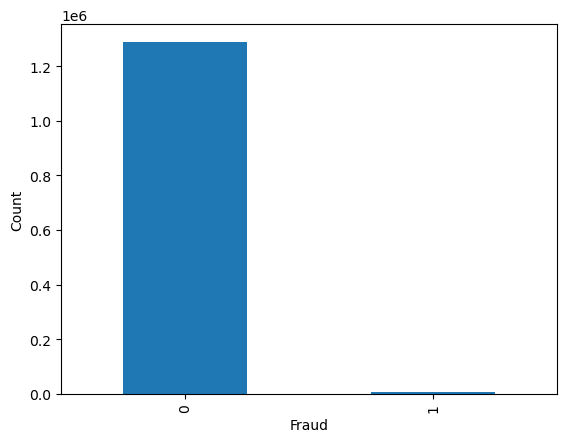

In [46]:
data_train['is_fraud'].value_counts().plot(kind = 'bar')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

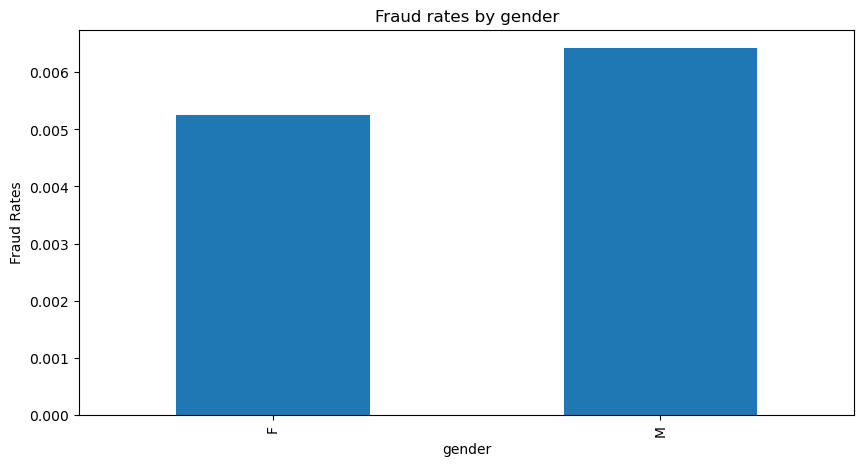

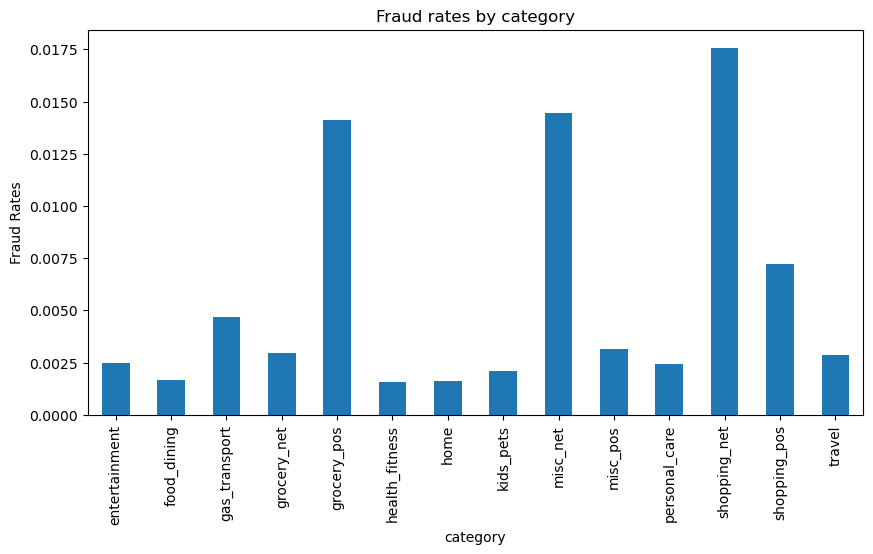

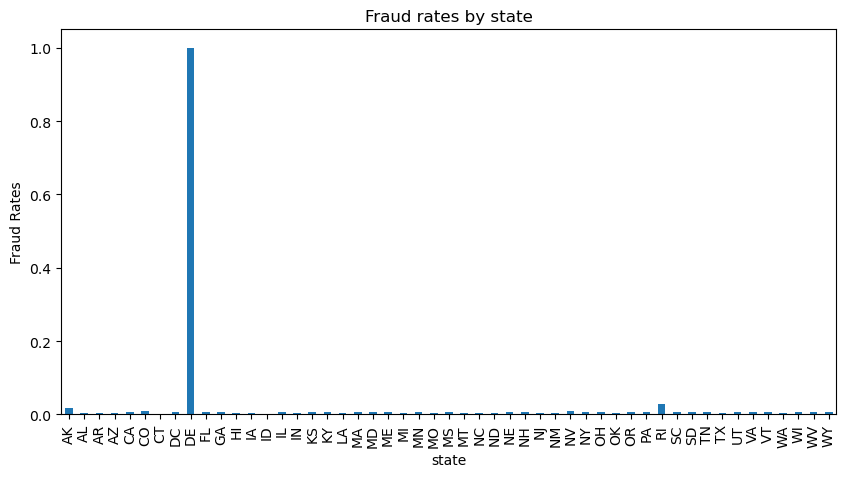

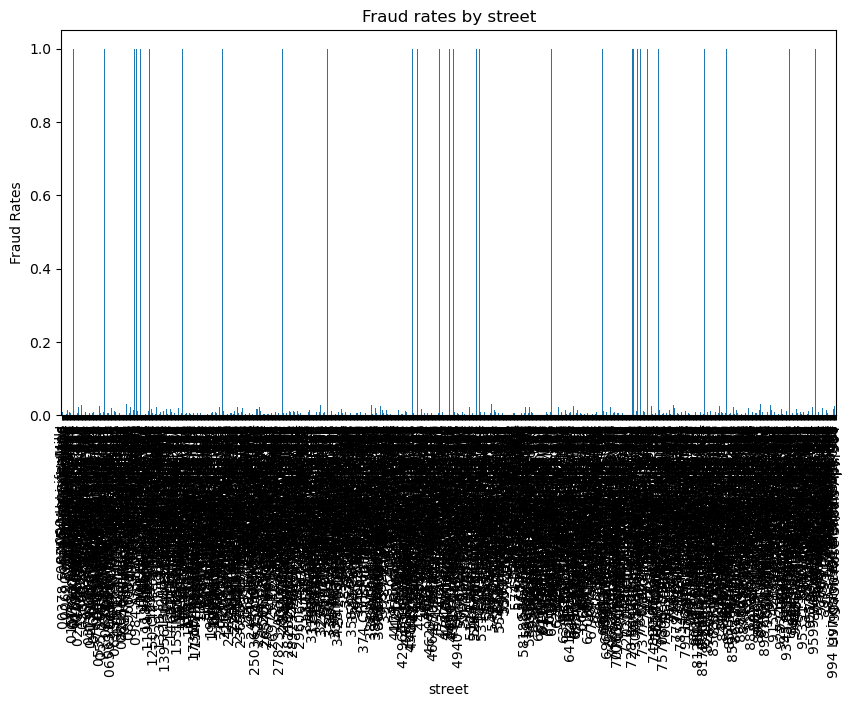

In [47]:
for i in ['gender', 'category','state','street']:
    plt.figure(figsize = (10, 5))
    data_train.groupby(i)['is_fraud'].mean().plot(kind = 'bar', title = f'Fraud rates by {i}')
    plt.xlabel(i)
    plt.ylabel('Fraud Rates')
    plt.xticks(rotation = 90)
    plt.show()

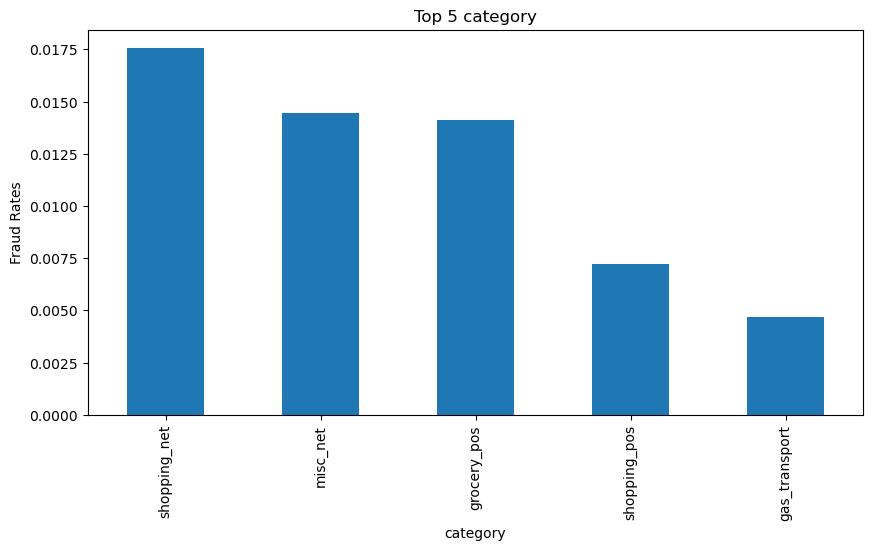

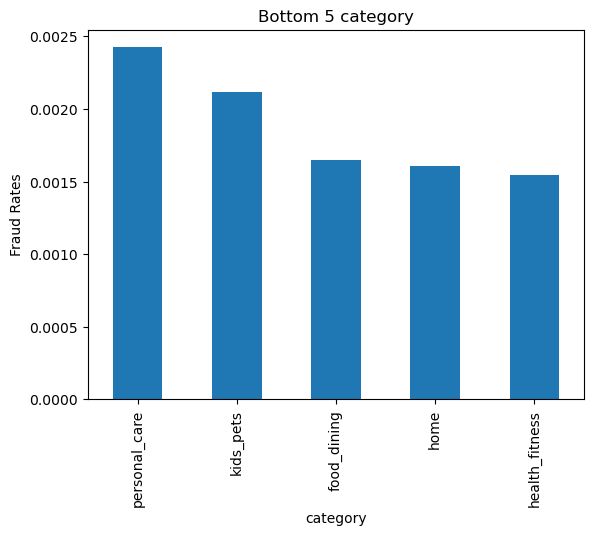

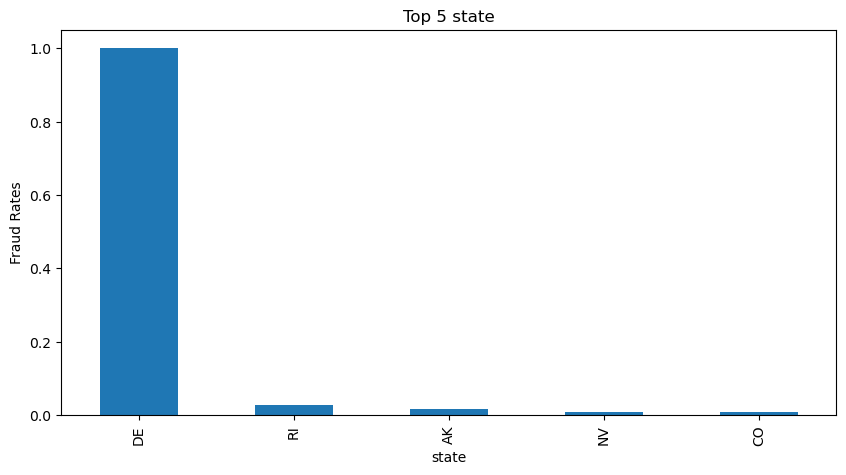

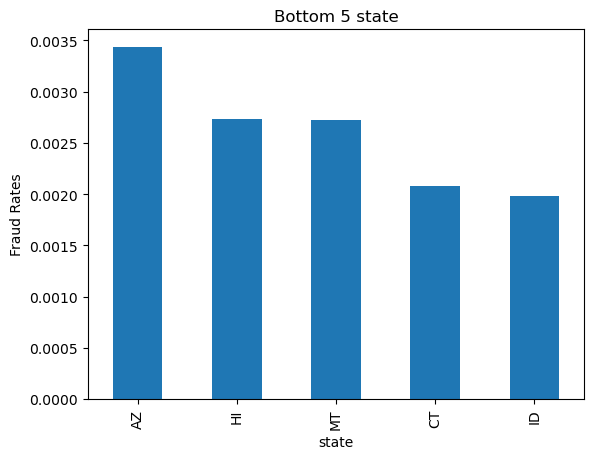

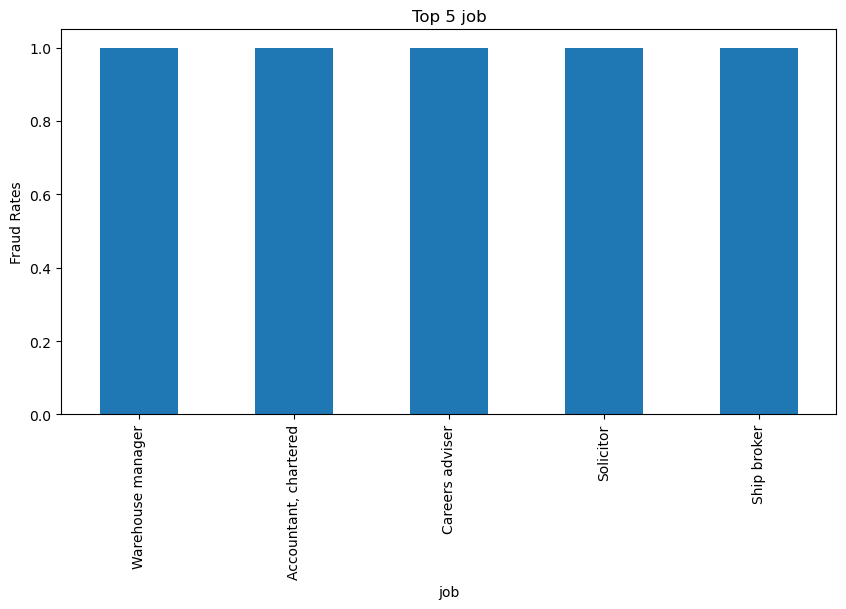

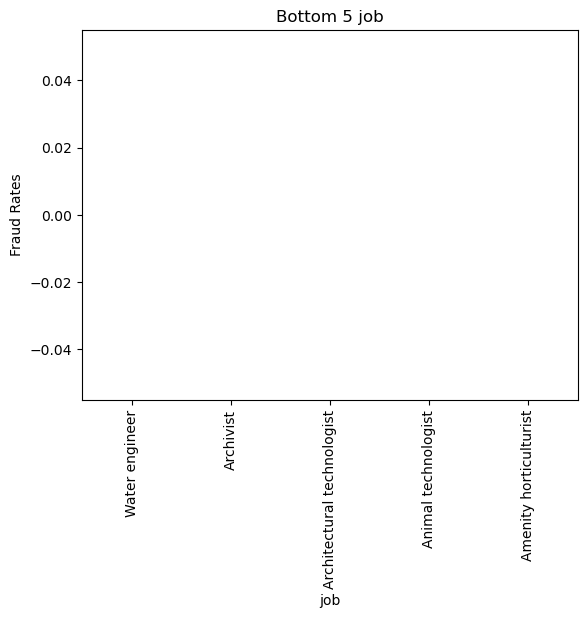

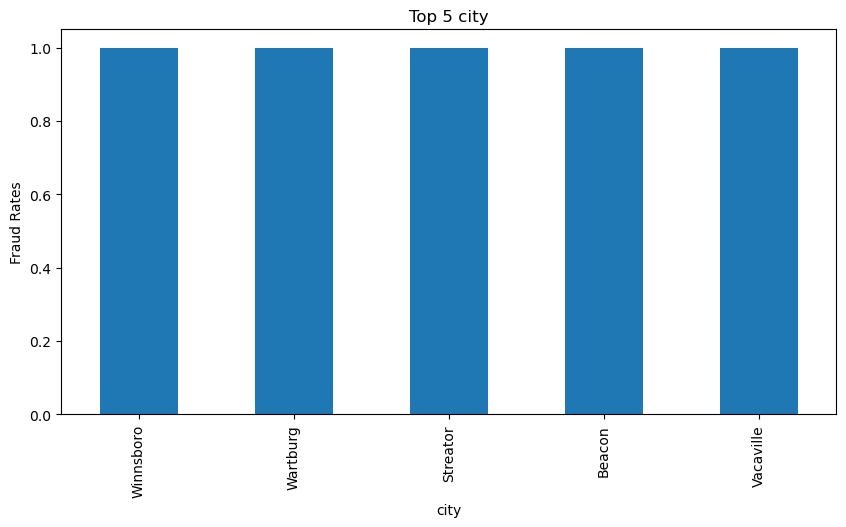

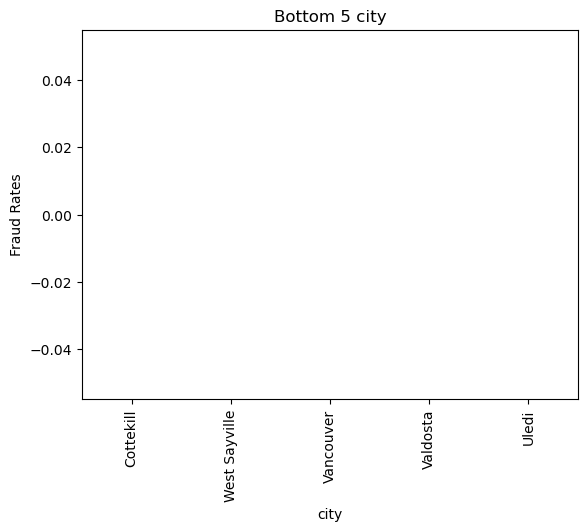

In [48]:
#top 5 is fraud state
for i in ['category','state', 'job', 'city']:
    plt.figure(figsize = (10, 5))
    data_train.groupby(i)['is_fraud'].mean().sort_values(ascending = False)[:5].plot(kind = 'bar', title = f'Top 5 {i}')
    plt.xlabel(i)
    plt.ylabel('Fraud Rates')
    plt.show()

    data_train.groupby(i)['is_fraud'].mean().sort_values(ascending = False)[-5:].plot(kind = 'bar', title = f'Bottom 5 {i}')
    plt.xlabel(i)
    plt.ylabel('Fraud Rates')
    plt.show()

## Feature Engineering

### Time Features

In [49]:
data_train['trans_date_trans_time'] = pd.to_datetime(data_train['trans_date_trans_time'])

data_train['Hour'] = data_train['trans_date_trans_time'].dt.hour
data_train['DayOfWeek'] = data_train['trans_date_trans_time'].dt.dayofweek
data_train['Month'] = data_train['trans_date_trans_time'].dt.month
data_train['Weekend'] = data_train['DayOfWeek'].isin([5, 6]).astype(int)

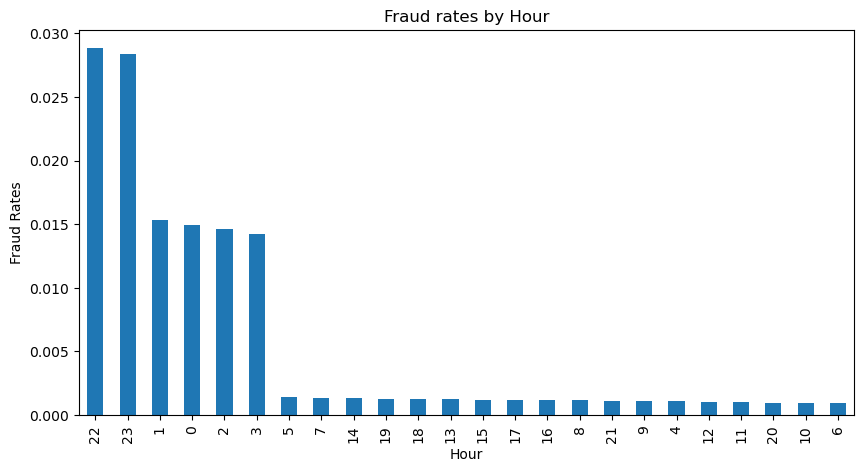

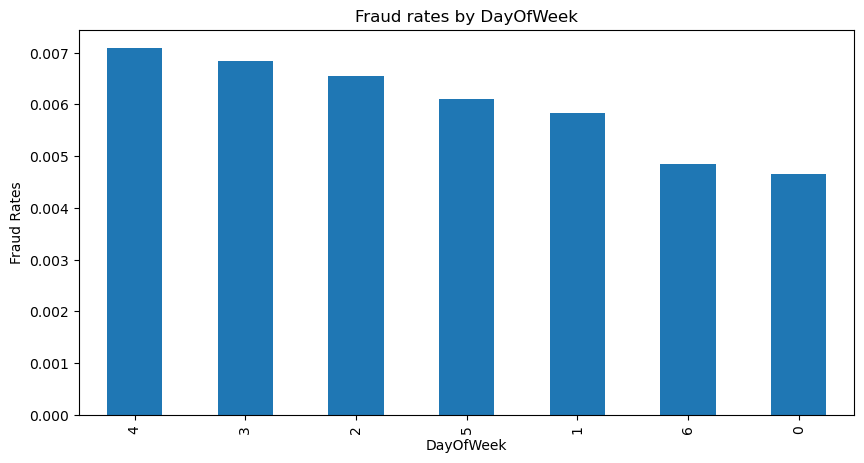

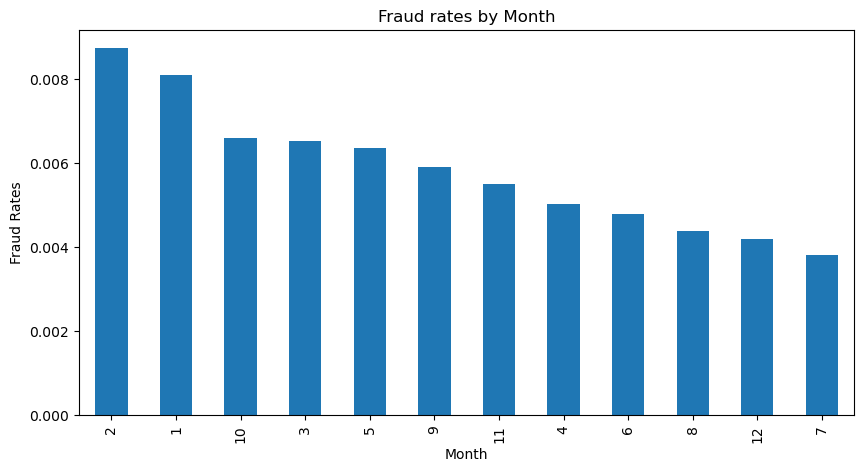

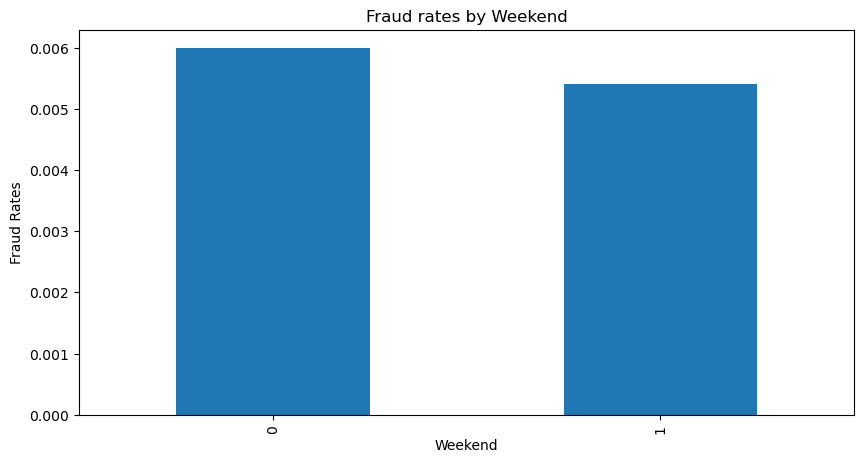

In [50]:
for i in ['Hour', 'DayOfWeek', 'Month', 'Weekend']:
  plt.figure(figsize = (10, 5))
  data_train.groupby(i)['is_fraud'].mean().sort_values(ascending = False).plot(kind = 'bar', title = f'Fraud rates by {i}')
  plt.xlabel(i)
  plt.ylabel('Fraud Rates')
  plt.show()

### Time Series Von Mises

In [51]:
# assume data_train['trans_date_trans_time'] is datetime
data_train['hour'] = data_train['trans_date_trans_time'].dt.hour + data_train['trans_date_trans_time'].dt.minute/60

data_train['theta'] = 2 * np.pi * data_train['hour'] / 24

mu_vm = circmean(data_train['theta'], high=2*np.pi, low=0)
sigma_vm = circstd(data_train['theta'], high=2*np.pi, low=0)

# von Mises pdf value for each transaction time
data_train['vm_pdf'] = vonmises.pdf(data_train['theta'], kappa=1/sigma_vm, loc=mu_vm)

# distance from periodic mean (in radians)
data_train['vm_distance'] = np.cos(data_train['theta'] - mu_vm)

# indicator: how unusual is this transaction time?
data_train['vm_anomaly'] = (data_train['vm_pdf'] < data_train['vm_pdf'].quantile(0.05)).astype(int)

def customer_vm_features(subdf):
    mu = circmean(subdf['theta'], high=2*np.pi, low=0)
    sigma = circstd(subdf['theta'], high=2*np.pi, low=0)
    pdf = vonmises.pdf(subdf['theta'], kappa=1/sigma, loc=mu)
    return pd.DataFrame({
        'vm_mu': mu,
        'vm_sigma': sigma,
        'vm_pdf': pdf
    }, index=subdf.index)

data_train_vm = data_train.groupby('cc_num').apply(customer_vm_features).reset_index(level=0, drop=True)

In [52]:
data_train = pd.concat([data_train, data_train_vm], axis=1)

### Customer Information Features

In [53]:
def distance_merch(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

data_train['distance_merch'] = distance_merch(data_train['lat'], data_train['long'], data_train['merch_lat'], data_train['merch_long'])

In [54]:
def age(born):
    today = pd.Timestamp('now')
    return today.year - born.year - ((today.month - born.month) < 0)

data_train['dob'] = pd.to_datetime(data_train['dob'])
data_train['age'] = data_train['dob'].apply(age)

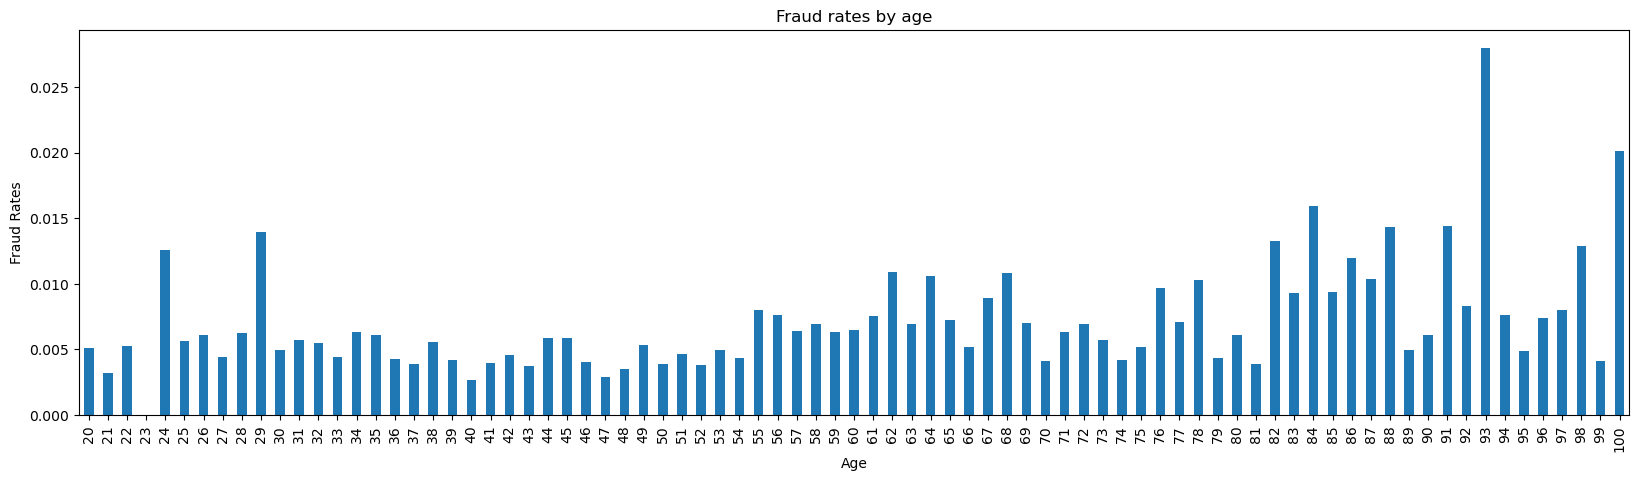

In [55]:
plt.figure(figsize = (20, 5))
data_train.groupby('age')['is_fraud'].mean().plot(kind = 'bar', title = 'Fraud rates by age')
plt.xlabel('Age')
plt.ylabel('Fraud Rates')
plt.xticks(rotation = 90)
plt.show()

### Customer Behavior

In [56]:
#time since last transaction
data_train['trans_date_trans_time'] = pd.to_datetime(data_train['trans_date_trans_time'])
data_train['time_since_last_transaction'] = data_train.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()
data_train['time_since_last_transaction']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
1296670    16781.0
1296671     7962.0
1296672    29074.0
1296673    91018.0
1296674    44250.0
Name: time_since_last_transaction, Length: 1296675, dtype: float64

In [57]:
#previous amount of the transaction
data_train['previous_amount'] = data_train.groupby('cc_num')['amt'].shift(1)
data_train['previous_amount']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
            ...  
1296670     63.41
1296671    134.38
1296672      2.15
1296673    125.51
1296674     40.13
Name: previous_amount, Length: 1296675, dtype: float64

In [58]:
data_train.fillna(0, inplace = True)
data_train.isnull().sum().sum()

np.int64(0)

## Clean Data

In [59]:
num_columns = data_train.select_dtypes(include= ['int64', 'float64'])
cat_columns = data_train.select_dtypes(include= 'object')

In [60]:
# num_columns.head()

In [61]:
num_columns.drop(columns = ['Unnamed: 0', 'cc_num', 'zip', 'unix_time'], inplace = True)

In [62]:
# cat_columns.head()

In [63]:
import re
#remove 6 first letter from merchant columns
cat_columns['merchant'] = cat_columns['merchant'].str[6:]
#remove all number from street
def clean_street_name(street):
    # Remove leading numbers
    street = re.sub(r'^\d+\s*', '', street)
    # Remove trailing numbers
    street = re.sub(r'\s*\d+$', '', street)
    return street
cat_columns['street'] = cat_columns['street'].apply(clean_street_name)

In [64]:
cat_columns.drop( columns =  ['first','last', 'trans_num'], inplace = True)

In [65]:
df_train = pd.concat([num_columns, cat_columns], axis = 1)

## Correlation

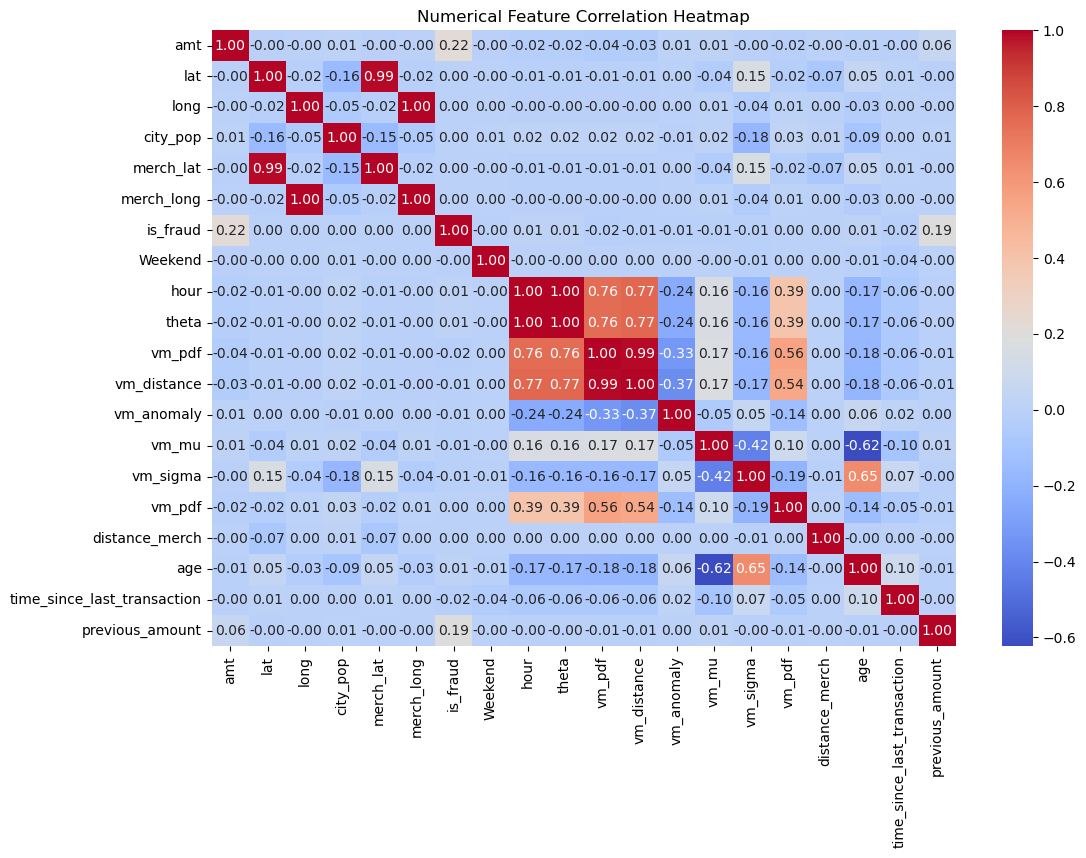

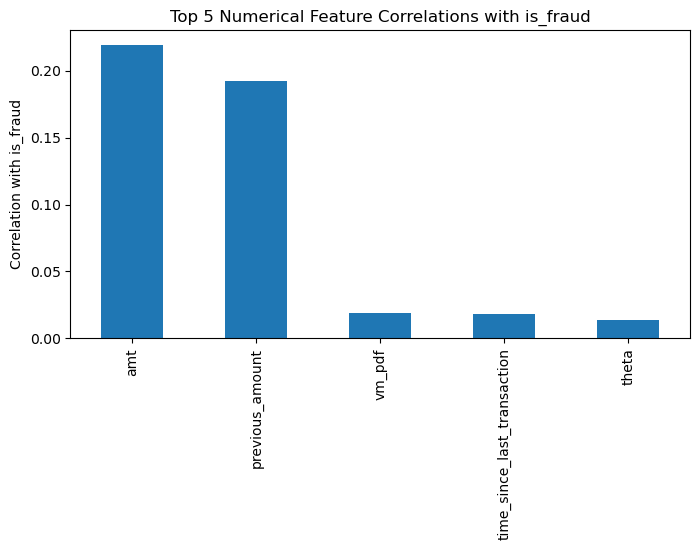

amt                            0.219404
previous_amount                0.192725
vm_pdf                         0.019051
time_since_last_transaction    0.018282
theta                          0.013831
Name: is_fraud, dtype: float64

In [ ]:
def plot_top_correlations(data, target='is_fraud', n=5):
    
    num_cols = data.select_dtypes(include=['int64', 'float64'])
    
    corr_matrix = num_cols.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Numerical Feature Correlation Heatmap")
    plt.show()
    
    target_corr = corr_matrix[target].drop(target).abs().sort_values(ascending=False)
    top_corr = target_corr.head(n)
    
    plt.figure(figsize=(8, 4))
    top_corr.plot(kind='bar')
    plt.ylabel('Correlation with {}'.format(target))
    plt.title(f'Top {n} Numerical Feature Correlations with {target}')
    plt.show()
    
    return top_corr

plot_top_correlations(df_train)

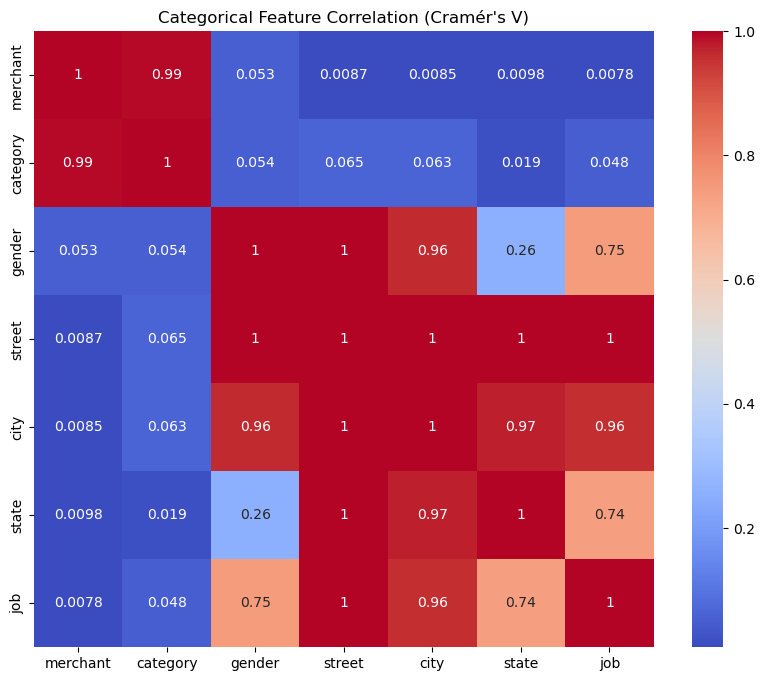

In [66]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_corr = pd.DataFrame(index=cat_columns.columns, columns=cat_columns.columns)
for col1 in cat_columns.columns:
    for col2 in cat_columns.columns:
        if col1 == col2:
            cat_corr.loc[col1, col2] = 1.0
        else:
            cat_corr.loc[col1, col2] = cramers_v(cat_columns[col1], cat_columns[col2])

cat_corr = cat_corr.astype(float)
plt.figure(figsize=(10,8))
sns.heatmap(cat_corr, annot=True, cmap='coolwarm')
plt.title("Categorical Feature Correlation (Cramér's V)")
plt.show()


# Encode

In [67]:
X = df_train.drop(columns = ['is_fraud'])
y = df_train['is_fraud']

In [68]:
from sklearn.preprocessing import OrdinalEncoder
import joblib
oe = OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value= -1)
X[cat_columns.columns] = oe.fit_transform(X[cat_columns.columns])
joblib.dump(oe, 'OrdinalEncoder.pkl')

['OrdinalEncoder.pkl']

#Scaler

In [69]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [70]:
print(f"X_train shape: ", X_train.shape)
print(f"y_train shape: ", y_train.shape)
print()
print(f"Training dataset fraud samples: ", y_train.value_counts())
print()
print()
print(f"X_test shape: ", X_test.shape)
print(f"y-test shape: ", y_test.shape)
print()
print(f"Testing dataset fraud samples: ", y_test.value_counts())

X_train shape:  (1037340, 26)
y_train shape:  (1037340,)

Training dataset fraud samples:  is_fraud
0    1031354
1       5986
Name: count, dtype: int64


X_test shape:  (259335, 26)
y-test shape:  (259335,)

Testing dataset fraud samples:  is_fraud
0    257815
1      1520
Name: count, dtype: int64


In [71]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
# X_test = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)
joblib.dump(scaler, "StandardScaler.pkl")

['StandardScaler.pkl']


Logistic Regression
[[245304  12511]
 [   207   1313]]
              precision    recall  f1-score   support

           0     0.9992    0.9515    0.9747    257815
           1     0.0950    0.8638    0.1711      1520

    accuracy                         0.9510    259335
   macro avg     0.5471    0.9076    0.5729    259335
weighted avg     0.9939    0.9510    0.9700    259335

ROC AUC: 0.9554028133188118
PR AUC: 0.28314979122154255

XGBoost
[[257630    185]
 [    57   1463]]
              precision    recall  f1-score   support

           0     0.9998    0.9993    0.9995    257815
           1     0.8877    0.9625    0.9236      1520

    accuracy                         0.9991    259335
   macro avg     0.9438    0.9809    0.9616    259335
weighted avg     0.9991    0.9991    0.9991    259335

ROC AUC: 0.9995547373320527
PR AUC: 0.9822868721698529


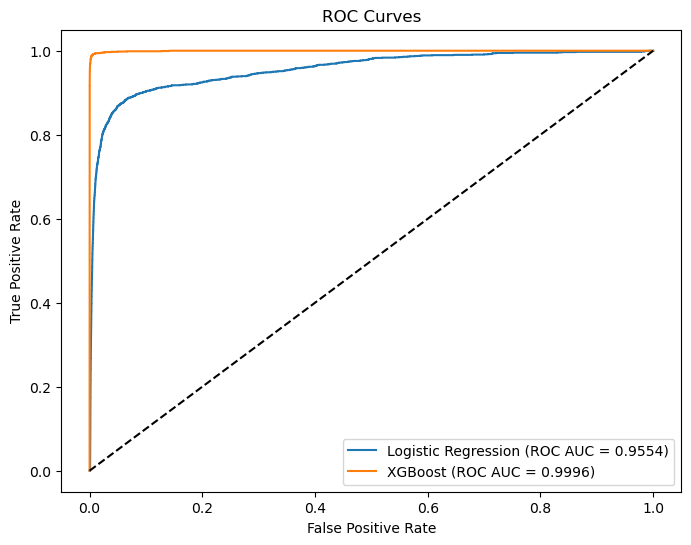

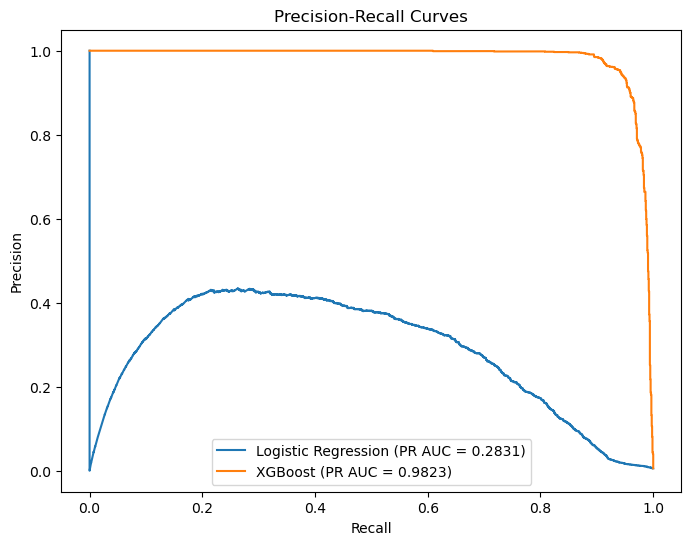

                        Feature   Importance
0                           amt  2577.105957
17              previous_amount  1566.873291
7                          hour   924.216858
19                     category   480.331116
8                         theta   333.987793
16  time_since_last_transaction   228.627609
13                     vm_sigma   165.127472
10                  vm_distance   109.298470
9                        vm_pdf   108.981255
15                          age   102.310539
12                        vm_mu    99.364159
20                       gender    81.257225
3                      city_pop    49.978405
2                          long    38.590202
23                        state    36.201256
1                           lat    32.657249
21                       street    27.597160
14               distance_merch    27.478428
5                    merch_long    27.060026
24                          job    26.662313


In [72]:


scale_pos = (y_train.value_counts()[0] / y_train.value_counts()[1])

models = {
    # "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    # "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42), 
    "XGBoost": XGBClassifier(n_estimators=500, 
                                learning_rate=0.1, 
                                max_depth=6, 
                                min_child_weight=5, 
                                gamma=0.1, 
                                subsample=0.8, 
                                colsample_bytree=0.8, 
                                reg_alpha=0.5,
                                reg_lambda=1,
                                n_jobs=-1,
                                random_state=42,
                                scale_pos_weight= scale_pos)
}

plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    joblib.dump(model, f"{name}_raw.joblib")
    
    print(f"\n{name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("PR AUC:", average_precision_score(y_test, y_prob))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (ROC AUC = {roc_auc_score(y_test, y_prob):.4f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {average_precision_score(y_test, y_prob):.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

if name == 'XGBoost':
    feature_names = X.columns

    importance = model.get_booster().get_score(importance_type='gain')

    importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items()}

    importance_df = pd.DataFrame({
        'Feature': importance_named.keys(),
        'Importance': importance_named.values()
    }).sort_values(by='Importance', ascending=False)

    print(importance_df.head(20))

    


# Model Training UnderSampled data

In [73]:

# Near Miss version 1
undersample = NearMiss(version=1, n_neighbors=3)
X_res, y_res = undersample.fit_resample(X_train, y_train)
print(f'NearMissUnderSampling: {y_res.value_counts()}')
print()

#RandomeUnderSampling
rud = RandomUnderSampler(random_state= 42)
X_rdres, y_rndres = rud.fit_resample(X_train, y_train)
print(f'RandomUnderSampling: {y_rndres.value_counts()}')

NearMissUnderSampling: is_fraud
0    5986
1    5986
Name: count, dtype: int64

RandomUnderSampling: is_fraud
0    5986
1    5986
Name: count, dtype: int64


In [74]:
# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators = 200, max_depth = 25, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier( n_estimators=500, 
                                learning_rate=0.1, 
                                max_depth=6, 
                                min_child_weight=5, 
                                gamma=0.1, 
                                subsample=0.8, 
                                colsample_bytree=0.8, 
                                reg_alpha=0.5,
                                reg_lambda=1,
                                tree_method="hist",   
                                n_jobs=-1,
                                random_state=42,
                                scale_pos_weight=1)
}



Random Forest
[[139464 118351]
 [    22   1498]]
              precision    recall  f1-score   support

           0     0.9998    0.5409    0.7021    257815
           1     0.0125    0.9855    0.0247      1520

    accuracy                         0.5436    259335
   macro avg     0.5062    0.7632    0.3634    259335
weighted avg     0.9941    0.5436    0.6981    259335

ROC AUC: 0.9755686630662337
PR AUC: 0.7089848462746756

Logistic Regression
[[191559  66256]
 [   164   1356]]
              precision    recall  f1-score   support

           0     0.9991    0.7430    0.8522    257815
           1     0.0201    0.8921    0.0392      1520

    accuracy                         0.7439    259335
   macro avg     0.5096    0.8176    0.4457    259335
weighted avg     0.9934    0.7439    0.8475    259335

ROC AUC: 0.9078678484266054
PR AUC: 0.1889920053702778

Decision Tree
[[177320  80495]
 [    35   1485]]
              precision    recall  f1-score   support

           0     0.9998  

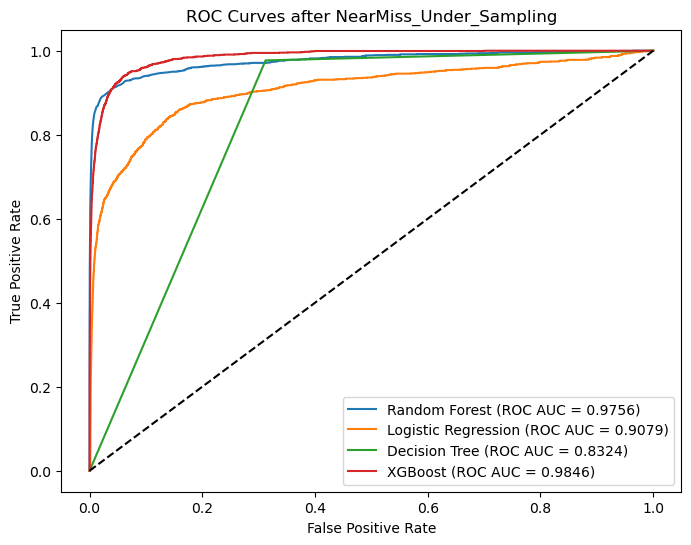

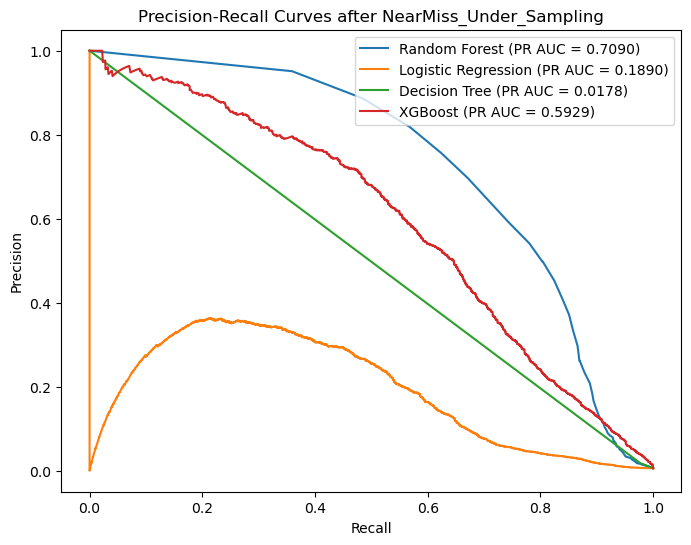

                        Feature  Importance
19                       gender   59.349422
0                           amt   48.824203
16              previous_amount   29.914347
8                         theta   16.018270
7                          hour   12.882187
14                          age    9.918433
11                        vm_mu    8.469295
18                     category    7.439250
15  time_since_last_transaction    6.368277
6                       Weekend    6.298923
12                     vm_sigma    4.939129
10                  vm_distance    2.423251
21                         city    2.072727
23                          job    2.019179
1                           lat    1.865783
2                          long    1.840759
9                        vm_pdf    1.391490
22                        state    1.186150
13               distance_merch    1.148522
5                    merch_long    1.068705


In [75]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    joblib.dump(model, f"{name}_nearmiss.joblib")

    print(f"\n{name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("PR AUC:", average_precision_score(y_test, y_prob))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (ROC AUC = {roc_auc_score(y_test, y_prob):.4f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves after NearMiss_Under_Sampling")
plt.legend()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {average_precision_score(y_test, y_prob):.4f})")
    
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves after NearMiss_Under_Sampling")
plt.legend()
plt.show()

if name == 'XGBoost':
    feature_names = X.columns

    importance = model.get_booster().get_score(importance_type='gain')

    importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items()}

    importance_df = pd.DataFrame({
        'Feature': importance_named.keys(),
        'Importance': importance_named.values()
    }).sort_values(by='Importance', ascending=False)

    print(importance_df.head(20))



Random Forest
[[252738   5077]
 [    33   1487]]
              precision    recall  f1-score   support

           0     0.9999    0.9803    0.9900    257815
           1     0.2265    0.9783    0.3679      1520

    accuracy                         0.9803    259335
   macro avg     0.6132    0.9793    0.6789    259335
weighted avg     0.9953    0.9803    0.9863    259335

ROC AUC: 0.9966641892850545
PR AUC: 0.9182064686879791

Logistic Regression
[[245604  12211]
 [   206   1314]]
              precision    recall  f1-score   support

           0     0.9992    0.9526    0.9753    257815
           1     0.0972    0.8645    0.1747      1520

    accuracy                         0.9521    259335
   macro avg     0.5482    0.9086    0.5750    259335
weighted avg     0.9939    0.9521    0.9707    259335

ROC AUC: 0.9547281965750637
PR AUC: 0.2828862390440712

Decision Tree
[[248775   9040]
 [    50   1470]]
              precision    recall  f1-score   support

           0     0.9998  

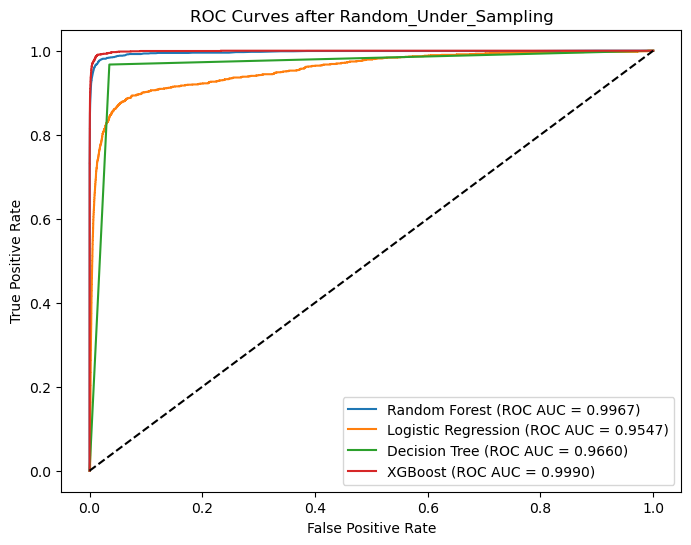

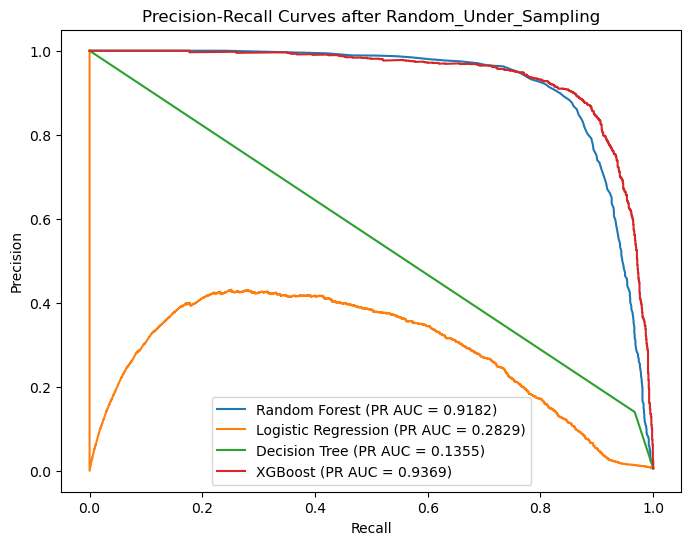

                        Feature  Importance
0                           amt   39.545349
16              previous_amount   23.940491
7                          hour   18.686724
8                         theta    9.214685
18                     category    6.854122
15  time_since_last_transaction    4.879140
12                     vm_sigma    3.472011
19                       gender    2.100726
9                        vm_pdf    2.011965
11                        vm_mu    2.009578
14                          age    1.963375
10                  vm_distance    1.586684
3                      city_pop    1.458865
22                        state    1.116315
1                           lat    0.910332
2                          long    0.893594
23                          job    0.842361
21                         city    0.821772
5                    merch_long    0.786278
20                       street    0.731814


In [76]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_rdres, y_rndres)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    joblib.dump(model, f"{name}_rud.joblib")

    print(f"\n{name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("PR AUC:", average_precision_score(y_test, y_prob))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (ROC AUC = {roc_auc_score(y_test, y_prob):.4f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves after Random_Under_Sampling")
plt.legend()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {average_precision_score(y_test, y_prob):.4f})")

    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves after Random_Under_Sampling")
plt.legend()
plt.show()

if name == 'XGBoost':
    feature_names = X.columns

    importance = model.get_booster().get_score(importance_type='gain')

    importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items()}

    importance_df = pd.DataFrame({
        'Feature': importance_named.keys(),
        'Importance': importance_named.values()
    }).sort_values(by='Importance', ascending=False)

    print(importance_df.head(20))

# Model Training OverandUnderSampled (SMOTE) data

In [77]:

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("\nBefore SMOTE:")
print("X shape:", X_train.shape)
print("y class distribution:\n", y_train.value_counts())

print("\nAfter SMOTE:")
print("X_resampled shape:", X_resampled.shape)
print("y_resampled class distribution:\n", y_resampled.value_counts())




Before SMOTE:
X shape: (1037340, 26)
y class distribution:
 is_fraud
0    1031354
1       5986
Name: count, dtype: int64

After SMOTE:
X_resampled shape: (2062708, 26)
y_resampled class distribution:
 is_fraud
0    1031354
1    1031354
Name: count, dtype: int64



Logistic Regression
[[244626  13189]
 [   210   1310]]
              precision    recall  f1-score   support

           0     0.9991    0.9488    0.9733    257815
           1     0.0904    0.8618    0.1636      1520

    accuracy                         0.9483    259335
   macro avg     0.5447    0.9053    0.5684    259335
weighted avg     0.9938    0.9483    0.9686    259335

ROC AUC: 0.954724641904589
PR AUC: 0.2850786190901207

XGBoost
[[257570    245]
 [    81   1439]]
              precision    recall  f1-score   support

           0     0.9997    0.9990    0.9994    257815
           1     0.8545    0.9467    0.8983      1520

    accuracy                         0.9987    259335
   macro avg     0.9271    0.9729    0.9488    259335
weighted avg     0.9988    0.9987    0.9988    259335

ROC AUC: 0.9991258394176975
PR AUC: 0.972078673666671


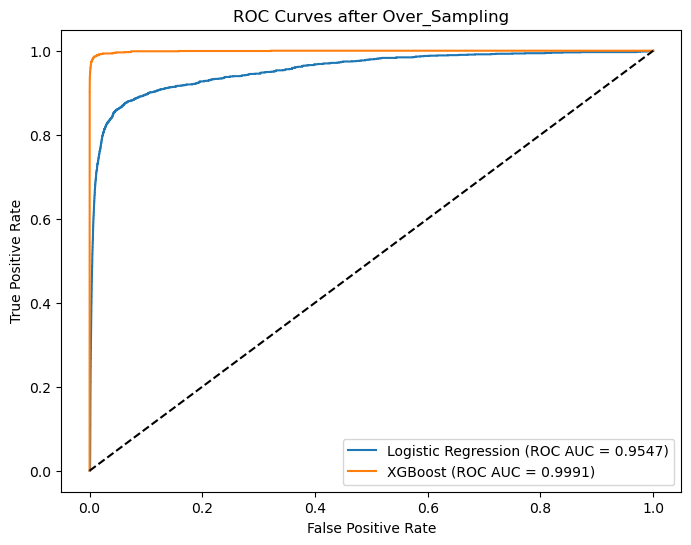

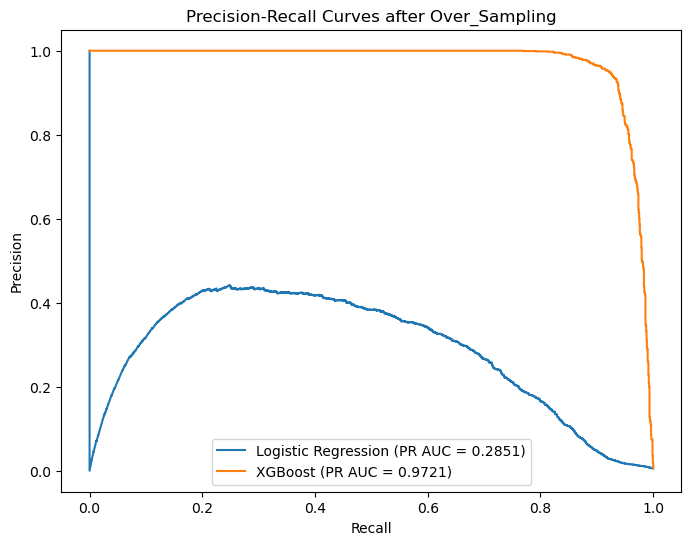

                        Feature   Importance
0                           amt  2661.368652
17              previous_amount  1703.266846
7                          hour   933.757019
19                     category   581.492126
8                         theta   541.898987
20                       gender   351.223541
6                       Weekend   207.142685
16  time_since_last_transaction   201.525177
10                  vm_distance   195.149567
13                     vm_sigma   165.162231
9                        vm_pdf   101.238350
12                        vm_mu    89.257256
15                          age    68.746117
23                        state    51.385971
1                           lat    39.049576
2                          long    37.969780
22                         city    33.866177
3                      city_pop    33.647469
24                          job    32.679626
21                       street    28.212620


In [78]:
# Models
models = {
    # "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    # "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42)
    "XGBoost": XGBClassifier( n_estimators=500, 
                                learning_rate=0.1, 
                                max_depth=6, 
                                min_child_weight=5, 
                                gamma=0.1, 
                                subsample=0.8, 
                                colsample_bytree=0.8, 
                                reg_alpha=0.5,
                                reg_lambda=1,
                                tree_method="hist",   
                                n_jobs=-1,
                                random_state=42,
                                scale_pos_weight=1)
}

plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    joblib.dump(model, f"{name}_SMOTE.joblib")

    print(f"\n{name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("PR AUC:", average_precision_score(y_test, y_prob))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (ROC AUC = {roc_auc_score(y_test, y_prob):.4f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves after Over_Sampling")
plt.legend()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {average_precision_score(y_test, y_prob):.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves after Over_Sampling")
plt.legend()
plt.show()

if name == 'XGBoost':
    feature_names = X.columns

    importance = model.get_booster().get_score(importance_type='gain')

    importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items()}

    importance_df = pd.DataFrame({
        'Feature': importance_named.keys(),
        'Importance': importance_named.values()
    }).sort_values(by='Importance', ascending=False)

    print(importance_df.head(20))

In [79]:
end_time = time.time()
total_runtime = end_time - start_time
print(f"Total runtime: {total_runtime:.2f} seconds")

Total runtime: 394.45 seconds
